OSMnx is a Python package to retrieve, model, analyze, and visualize street networks from OpenStreetMap. Users can download and model walkable, drivable, or bikeable urban networks with a single line of Python code, and then easily analyze and visualize them. 





Boeing, G. 2017. OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks. Computers, Environment and Urban Systems 65, 126-139. doi:10.1016/j.compenvurbsys.2017.05.004

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox
import networkx as nx
import numpy as np
from matplotlib import *
from IPython.display import Image
import folium

### OSM street network

In [ ]:
# Specify the name that is used to seach for the data
#place = "Helsinki, Finland"
#place = "Toronto, Canada"
place = "Varberg, Sweden"

# Fetch OSM street network from the location and plot in Folium map
G = ox.graph_from_place(place, network_type="all")
# Convert graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
edges= ox.graph_to_gdfs(G, edges=True, nodes=False)
m = ox.plot_graph_folium(G, popup_attribute="name", weight=2, color="#808080")


In [3]:
G = ox.graph_from_place(place, network_type="all")

### Calculate basic street network measures (topological and geometric)

#### Basic street network stats

In [4]:
# Network cover in square meters
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
# statistics
stats = ox.basic_stats(G, area=graph_area_m)
for k, count in stats["streets_per_node_counts"].items():
    stats["{}way_int_count".format(k)] = count
for k, proportion in stats["streets_per_node_proportions"].items():
    stats["{}way_int_prop".format(k)] = proportion

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name="value")).round(3)

,value
n,19197.000
m,49282.000
k_avg,5.134
edge_length_total,6505427.640
edge_length_avg,132.004
streets_per_node_avg,2.640
intersection_count,14678.000
street_length_total,3324541.291
street_segment_count,25306.000
street_length_avg,131.374


* circuity_avg - Calculate average street circuity using edges of undirected graph.Circuity is the sum of edge lengths divided by the sum of straight-line distances between edge endpoints. Calculates straight-line distance as euclidean distance if projected or great-circle distance if unprojected.
* clean_intersection_count - see clean_intersection_count function documentation
* clean_intersection_density_km - clean_intersection_count per sq km
* edge_density_km - edge_length_total per sq km
* edge_length_avg - edge_length_total / m
* edge_length_total -Graph’s total edge length.
* intersection_count - Count the intersections in a graph.
* intersection_density_km - intersection_count per sq km
* k_avg - graph’s average node degree (in-degree and out-degree)
* m - count of edges in graph
* n - count of nodes in graph
* node_density_km - n per sq km
* self_loop_proportion - see self_loop_proportion function documentation
* street_density_km - street_length_total per sq km
* street_length_avg - street_length_total / street_segment_count
* street_length_total -  graph’s total street segment length.
* street_segment_count - Count the street segments in a graph
* streets_per_node_avg - Calculate graph’s average count of streets per node.
* streets_per_node_counts - Calculate streets-per-node counts.
* streets_per_node_proportions - Calculate streets-per-node proportions.

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

 #### Comparing Street density (street_length_total per sq km)

In [5]:
drv_grph = ox.graph_from_place(place, network_type="drive")
# calculate basic and extended network stats, merge them together, and display
G_proj = ox.project_graph(drv_grph)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
stats = ox.basic_stats(drv_grph, area=graph_area_m)
drive_street_len = stats["street_density_km"]

In [6]:
bike_grph = ox.graph_from_place(place, network_type="bike")
# calculate basic and extended network stats, merge them together, and display
G_proj = ox.project_graph(bike_grph)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
stats = ox.basic_stats(bike_grph, area=graph_area_m)
bike_street_len = stats["street_density_km"]

In [7]:
walk_grph = ox.graph_from_place(place, network_type="walk")
# calculate basic and extended network stats, merge them together, and display
# What sized area does our network cover in square meters
G_proj = ox.project_graph(walk_grph)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
stats = ox.basic_stats(bike_grph, area=graph_area_m)
walkable_street_len = stats["street_density_km"]

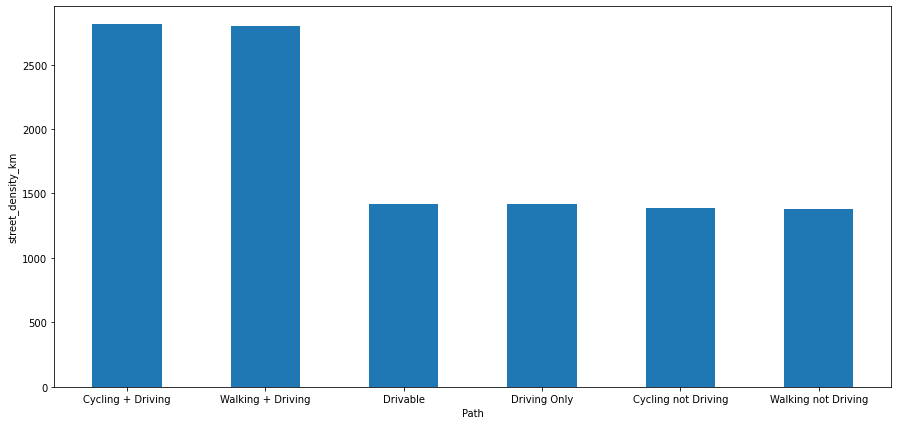

In [8]:
bike_only_len = bike_street_len - drive_street_len
walk_only_len = walkable_street_len - drive_street_len
drive_only_len = walkable_street_len - (walk_only_len )

# creating the dataset
data = {'Cycling + Driving':bike_street_len, 
        'Walking + Driving':walkable_street_len,
        'Drivable':drive_street_len, 
        'Driving Only': drive_only_len, 
        'Cycling not Driving': bike_only_len,
       'Walking not Driving': walk_only_len,
       }
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (15, 7))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.5)
 
plt.xlabel("Path")
plt.ylabel("street_density_km")
plt.show()

Street density for Cycling and Walking paths are quite high than Driving paths. Also, paths that are accessible by Walking or Cycling and not be driving are also visualized

### Plotting Map Features

More details about the Map Features - https://wiki.openstreetmap.org/wiki/Map_features

#### Hospitals

In [9]:
# List key-value pairs for tags such as hospital
tags = {'amenity': 'hospital'}
# Retrieve hospital
hospital = ox.geometries_from_place(place, tags)
# getting centroids from hospital to avoid polygon geometric objects
hospital['geometry'] = [geom.centroid for geom in hospital['geometry']]
# reset index
hospital = hospital.reset_index(drop=True)
centroids = hospital.centroid
lons = list(centroids.x)
lats = list(centroids.y)
name = list(hospital.name)
building_coords = [[lats[i],lons[i],name[i]] for i in range(len(lons))]

dictionary = dict()

for i in range(len(building_coords)):
     node_id = i+1
     dictionary[node_id] = {
    'x': lons[i],
    'y': lats[i],
    'name':name[i]
     }

tmp_list = []
for item_key, item_value in dictionary.items() :
  tmp_list.append({
    'geometry' : Point(item_value['x'], item_value['y']),
    'osmid': item_key,
    'y' : item_value['y'],
    'x' : item_value['x'],
    'name':item_value['name']
   })
my_nodes = gpd.GeoDataFrame(tmp_list)

# Plot the building nodes
hospital_nodes = my_nodes

C:\Users\geeth\AppData\Local\Temp/ipykernel_25892/3619979740.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = hospital.centroid


#### Bus Stations

In [10]:
# List key-value pairs for tags such as restaurants
tags = {'public_transport' : 'stop_position'}
# Retrieve restaurants
bus_stop = ox.geometries_from_place(place, tags)
# getting centroids from restaurants to avoid polygon geometric objects
bus_stop['geometry'] = [geom.centroid for geom in bus_stop['geometry']]
# reset index
bus_stop = bus_stop.reset_index(drop=True)
centroids = bus_stop.centroid
lons = list(centroids.x)
lats = list(centroids.y)
name = list(bus_stop.name)
building_coords = [[lats[i],lons[i],name[i]] for i in range(len(lons))]

dictionary = dict()

for i in range(len(building_coords)):
     node_id = i+1
     dictionary[node_id] = {
    'x': lons[i],
    'y': lats[i],
    'name':name[i]
     }

tmp_list = []
for item_key, item_value in dictionary.items() :
  tmp_list.append({
    'geometry' : Point(item_value['x'], item_value['y']),
    'osmid': item_key,
    'y' : item_value['y'],
    'x' : item_value['x'],
    'name':item_value['name']
   })
my_nodes = gpd.GeoDataFrame(tmp_list)

#Plot the building nodes
bus_nodes = my_nodes


C:\Users\geeth\AppData\Local\Temp/ipykernel_25892/3327883629.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = bus_stop.centroid


#### Parking Spots

In [11]:
# List key-value pairs for tags such as restaurants
tags = {'amenity' : 'parking'}
# Retrieve restaurants
parking = ox.geometries_from_place(place, tags)
# getting centroids from restaurants to avoid polygon geometric objects
parking['geometry'] = [geom.centroid for geom in parking['geometry']]
# reset index
parking = parking.reset_index(drop=True)
centroids = parking.centroid
lons = list(centroids.x)
lats = list(centroids.y)
name = list(parking.name)
building_coords = [[lats[i],lons[i],name[i]] for i in range(len(lons))]

dictionary = dict()

for i in range(len(building_coords)):
     node_id = i+1
     dictionary[node_id] = {
    'x': lons[i],
    'y': lats[i],
    'name':name[i]
     }

tmp_list = []
for item_key, item_value in dictionary.items() :
  tmp_list.append({
    'geometry' : Point(item_value['x'], item_value['y']),
    'osmid': item_key,
    'y' : item_value['y'],
    'x' : item_value['x'],
    'name':item_value['name']
   })
my_nodes = gpd.GeoDataFrame(tmp_list)

# Plot the building nodes
park_nodes = my_nodes


C:\Users\geeth\AppData\Local\Temp/ipykernel_25892/575059247.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = parking.centroid


#### Charging Stations

In [12]:
# List key-value pairs for tags such as restaurants
tags = {'amenity' : 'charging_station'}
# Retrieve restaurants
charging_station = ox.geometries_from_place(place, tags)
# getting centroids from restaurants to avoid polygon geometric objects
charging_station['geometry'] = [geom.centroid for geom in charging_station['geometry']]
# reset index
charging_station = charging_station.reset_index(drop=True)
centroids = charging_station.centroid
lons = list(centroids.x)
lats = list(centroids.y)
name = list(charging_station.name)
building_coords = [[lats[i],lons[i],name[i]] for i in range(len(lons))]
dictionary = dict()

for i in range(len(building_coords)):
     node_id = i+1
     dictionary[node_id] = {
    'x': lons[i],
    'y': lats[i],
    'name':name[i]
     }

tmp_list = []
for item_key, item_value in dictionary.items() :
  tmp_list.append({
    'geometry' : Point(item_value['x'], item_value['y']),
    'osmid': item_key,
    'y' : item_value['y'],
    'x' : item_value['x'],
    'name':item_value['name']
   })
my_nodes = gpd.GeoDataFrame(tmp_list)

# Plot the building nodes
charging_nodes = my_nodes


C:\Users\geeth\AppData\Local\Temp/ipykernel_25892/3160271649.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = charging_station.centroid


In [20]:
# Plot the street network with folium
G = ox.graph_from_place(place, network_type="drive")
m = ox.plot_graph_folium(G, popup_attribute="name", weight=2, color="#808080")
hospital_group = folium.FeatureGroup(name="Hospital").add_to(m)
bus_group = folium.FeatureGroup(name="Bus Station").add_to(m)
parking_group = folium.FeatureGroup(name="Parking Space").add_to(m)
charging_group = folium.FeatureGroup(name="Charging Station").add_to(m)
#Hospital
for i in range(hospital_nodes.shape[0]):
  location = [hospital_nodes.y.iloc[i], hospital_nodes.x.iloc[i],]
  loc_name = hospital_nodes.name.iloc[i]
  icon=folium.Icon(icon="fa-hospital-o", prefix='fa')
  hospital_group.add_child(folium.Marker(location=location, tooltip=loc_name, icon=icon).add_to(m))

#Bus Station    
for i in range(bus_nodes.shape[0]):
  location = [bus_nodes.y.iloc[i], bus_nodes.x.iloc[i],]
  loc_name = bus_nodes.name.iloc[i]
  icon=folium.Icon(icon="fa-bus", prefix='fa', color = "cadetblue")
  bus_group.add_child(folium.Marker(location=location, tooltip="Bus station", icon=icon).add_to(m))

#Parking Space       
for i in range(park_nodes.shape[0]):
  location = [park_nodes.y.iloc[i], park_nodes.x.iloc[i],]
  loc_name = park_nodes.name.iloc[i]
  icon=folium.Icon(icon="fa-map-marker", prefix='fa', color = 'green')
  parking_group.add_child(folium.CircleMarker(location=location, tooltip="Parking Space", radius=float(3),
      color='green',
      fill=True,
      fill_color='green').add_to(m))
    

#Charging Station
for i in range(charging_nodes.shape[0]):
  location = [charging_nodes.y.iloc[i], charging_nodes.x.iloc[i],]
  loc_name = charging_nodes.name.iloc[i]
  icon=folium.Icon(icon="fa-plug", prefix='fa', color = "orange")
  charging_group.add_child(folium.Marker(location=location, tooltip="Charging Station", icon=icon).add_to(m))
#folium.LayerControl().add_to(m)    
#display(m)


### Visualize street centrality - Driving Network

#### 1. Degree Centrality

The degree of a node is simply defined as the number of connecting edges that it has. The node ‘33’ has 17 edges connecting it, to other nodes in the network. This results in a degree of 17. To determine the degree centrality, the degree of a node is divided by the number of other nodes in the network (n-1). To continue with computing the degree centrality for node ‘33’, 17 / (34–1) results in 0.5152. Remember from above, the number of nodes in the dataset is 34.

An interpretation of this metric, Popularity.

In [14]:
degree_centrality = nx.degree_centrality(G)
# calculate betweenness with a digraph of G (ie, no parallel edges)
max_dc_node, max_dc = max(degree_centrality.items(), key=lambda x: x[1])
# For plotting on Folium map
for node in G.nodes:
    if node == max_dc_node:
        dc_nl = G.nodes[max_dc_node]['x']
        dc_ny = G.nodes[max_dc_node]['y']

#### 2. Eigenvector Centrality

The adjacency matrix allows the connectivity of a node to be expressed in matrix form. So, for non-directed networks, the matrix is symmetric. Eigenvector centrality uses this matrix to compute its largest, most unique eigenvalues. The resulting eigenvector is used as the metric. The basic idea behind this metric revolves around a nodes neighbors and how connected they are. To score higher, a node needs to be well connected (high degree centrality) but it also needs to be connected to others that are well connected.

An interpretation of this metric, Influence.

In [15]:
G2 = nx.DiGraph(G)
eigen_centrality = nx.eigenvector_centrality(G2, max_iter=1000)
#maximum  Eigenvector Centrality
max_ec_node, max_ec = max(eigen_centrality.items(), key=lambda x: x[1])
# For plotting on Folium map
for node in G.nodes:
    if node == max_ec_node:
        ec_nl = G.nodes[max_ec_node]['x']
        ec_ny = G.nodes[max_ec_node]['y']

#### 3. Closeness Centrality

An interpretation of this metric, Centralness.

In [16]:
closeness_centrality = nx.closeness_centrality(G)

max_cc_node, max_cc = max(closeness_centrality.items(), key=lambda x: x[1])

for node in G.nodes:
    if node == max_cc_node:
        cc_nl = G.nodes[max_cc_node]['x']
        cc_ny = G.nodes[max_cc_node]['y']

#### 4. Betweenness centrality


An interpretation of this metric, Bridge.

In [17]:
# calculate betweenness with a digraph of G (ie, no parallel edges). Considering k =1000 due to huge computation time
bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length", k=1000)
max_node, max_bc = max(bc.items(), key=lambda x: x[1])

for node in G.nodes:
    if node == max_node:
        bc_nl = G.nodes[max_node]['x']
        bc_ny = G.nodes[max_node]['y']

The relative betweenness centrality of every node in the graph is visualized below

In [21]:
c_group = folium.FeatureGroup(name="Centrality Measures").add_to(m)

# Betweenness Centrality
location = [bc_ny, bc_nl]
icon=folium.Icon(icon="fa", prefix='fa',color='red')
c_group.add_child(folium.Marker(location=location, icon=icon, tooltip = "Node with maximum Betweenness centrality").add_to(m))

# closeness Centrality
location = [cc_ny, cc_nl]
icon=folium.Icon(icon="fa", prefix='fa',color='red')
c_group.add_child(folium.Marker(location=location, icon=icon, tooltip = "Node with maximum Closeness centrality").add_to(m))


# Eigenvector Centrality 
location = [ec_ny, ec_nl]
icon=folium.Icon(icon="fa", prefix='fa',color='red')
c_group.add_child(folium.Marker(location=location, icon=icon, tooltip = "Node with maximum Eigenvector centrality").add_to(m))

# Degree Centrality 
location = [dc_ny, dc_nl]
icon=folium.Icon(icon="fa", prefix='fa',color='red')
c_group.add_child(folium.Marker(location=location, icon=icon, tooltip = "Node with maximum Degree centrality").add_to(m))

folium.LayerControl().add_to(m)    
#display(m)